# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 38
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews
Scraping page 21
   ---> 2100 total reviews
Scraping page 22
   ---> 2200 total reviews
Scraping page 23
   ---> 2300 total reviews
Scrapi

In [3]:
df = pd.DataFrame()
df["reviews"] = reviews

df.head()


,reviews
0,✅ Trip Verified | Absolutely horrible custome...
1,Not Verified | BA is not what it used to be! ...
2,"✅ Trip Verified | BA First, it's not even the..."
3,✅ Trip Verified | The worst business class ex...
4,Not Verified | Quite possibly the worst busin...


Now we have our dataset for this task! The loops above collected 3765 reviews by iterating through the paginated pages on the website.  The next thing that we should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [4]:

# Define a function to extract verification status and remove it from the review
def extract_verification(review):
    if review.startswith('✅ Trip Verified |'):
        return 'Verified', review.replace('✅ Trip Verified |', '')
    elif review.startswith('Not Verified |'):
        return 'Not Verified', review.replace('Not Verified |', '')
    else:
        return None, review

# Apply the function to the 'reviews' column
df['verification_status'], df['reviews'] = zip(*df['reviews'].map(extract_verification))

df.head()

,reviews,verification_status
0,Absolutely horrible customer service - will ...,Verified
1,BA is not what it used to be! As much as I l...,Not Verified
2,"BA First, it's not even the best business cl...",Verified
3,The worst business class experience. Ground ...,Verified
4,Quite possibly the worst business class I ha...,Not Verified


Sentiment Analysis

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


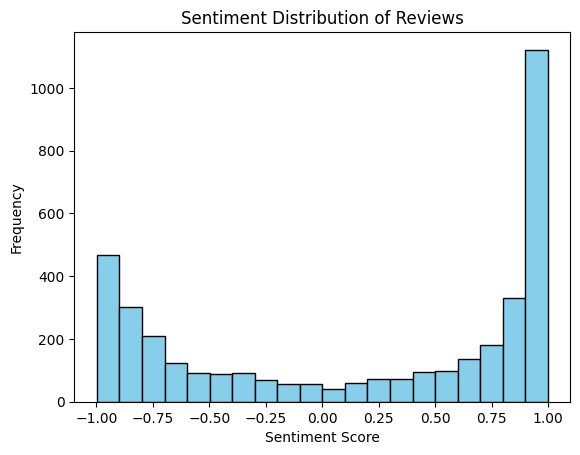

In [5]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis
df['sentiment_score'] = df['reviews'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Plot sentiment distribution
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('sentiment_analysis.png')
plt.show()


Topic Modeling

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the review data
X = vectorizer.fit_transform(df['reviews'])

# Initialize LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)

# Fit LDA to the transformed review data
lda.fit(X)

# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the topics
no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)


Topic 1:
flight british airways told ba customer service london did asked
Topic 2:
flight ba hours luggage london check heathrow staff time airport
Topic 3:
flight service crew food ba cabin london british airways time
Topic 4:
flight good seat ba food crew class cabin seats club
Topic 5:
ba class business seat flight seats airline british service airways


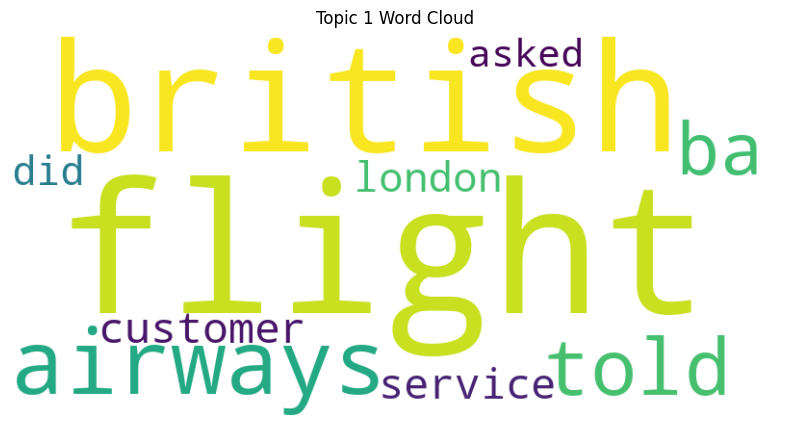

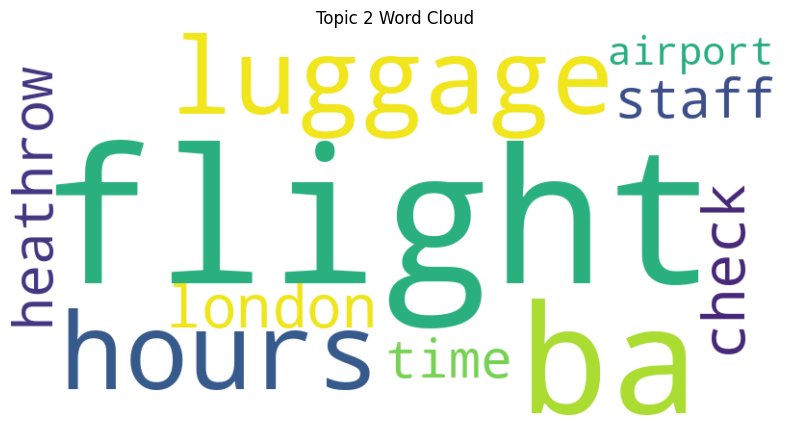

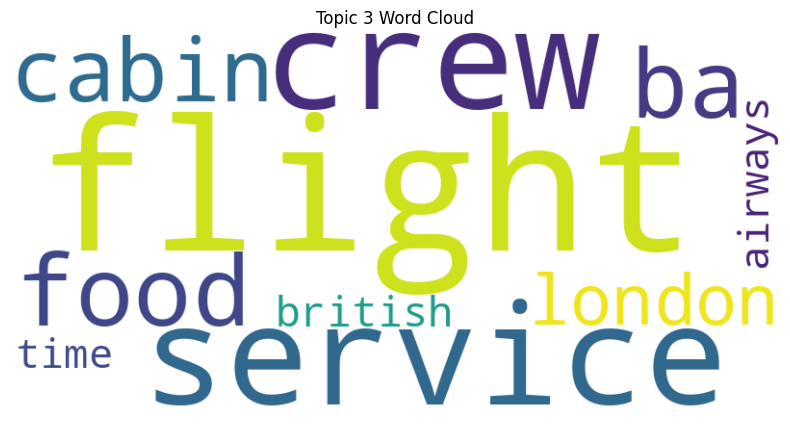

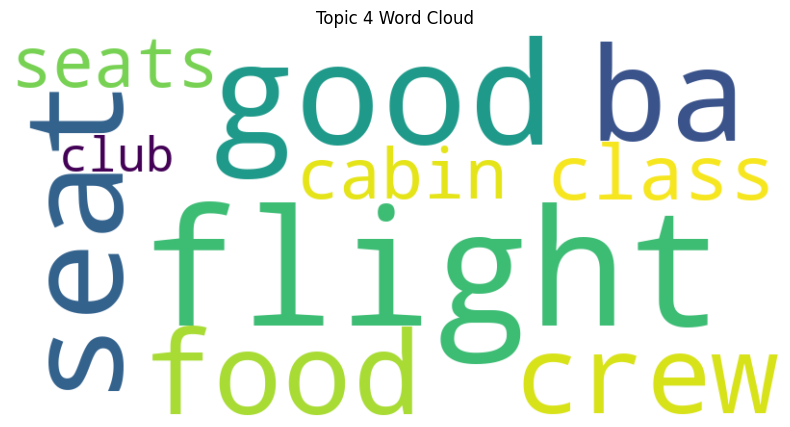

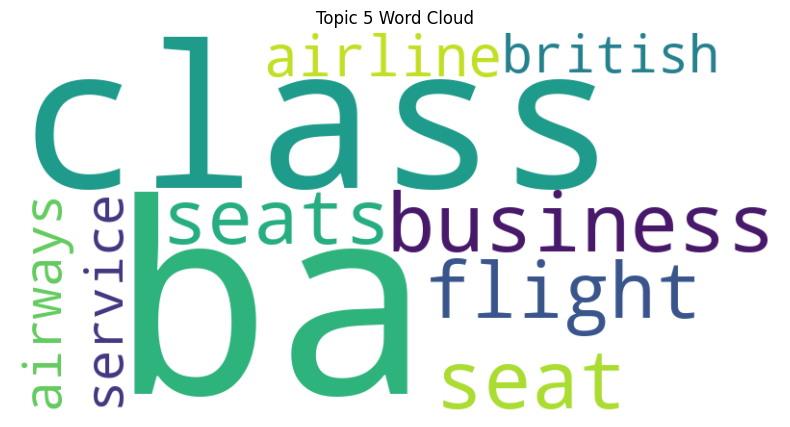

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud for each topic
def generate_word_cloud(lda_model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_idx+1} Word Cloud')
        plt.axis('off')
        plt.savefig(f'topic_{topic_idx+1}_wordcloud.png')
        plt.show()

# Generate word cloud for each topic
generate_word_cloud(lda, feature_names, no_top_words)
